# Educated Data Analysis (EDA) - Crops

In this notebook we will conduct and EDA and build models to predict the production of crops.

## Importing the data

In [1]:
# Importing necessary libraries and packages

import os
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from math import sqrt

sns.set(rc={'figure.figsize' :(12,10)})
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Define the sheet names or indices to import
sheet_stats = ['CropStats']

# Import the sheets into a single DataFrame
df = pd.concat(pd.read_excel('../../archive/food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx', sheet_name=sheet_stats))
df

Unnamed: 0  Harvest_year   admin0    admin1   crop  \
CropStats 0               0          1902  Austria       NaN  wheat   
          1               1          1903  Austria       NaN  wheat   
          2               2          1904  Austria       NaN  wheat   
          3               3          1905  Austria       NaN  wheat   
          4               4          1906  Austria       NaN  wheat   
...                     ...           ...      ...       ...    ...   
          36702       36702          2013    China  zhejiang  wheat   
          36703       36703          2014    China  zhejiang  wheat   
          36704       36704          2015    China  zhejiang  wheat   
          36705       36705          2016    China  zhejiang  wheat   
          36706       36706          2017    China  zhejiang  wheat   

                 hectares (ha)  production (tonnes)  year  yield(tonnes/ha)  \
CropStats 0                NaN                  NaN  1902          1.310000   
          1                NaN                  NaN  1903          1.470000   
          2                NaN                  NaN  1904          1.270000   
          3                NaN                  NaN  1905          1.330000   
          4                NaN                  NaN  1906          1.280000   
...                        ...                  ...   ...               ...   
          36702        75520.0             278300.0  2013          3.685117   
          36703        82120.0             309500.0  2014          3.768875   
          36704        89800.0             351300.0  2015          3.912027   
          36705        76590.0             253900.0  2016          3.315054   
          36706       103670.0             419200.0  2017          4.043600   

                 admin2 notes  
CropStats 0         NaN   NaN  
          1         NaN   NaN  
          2         NaN   NaN  
          3         NaN   NaN  
          4         NaN   NaN  
...                 ...   ...  
          36702     NaN   NaN  
          36703     NaN   NaN  
          36704     NaN   NaN  
          36705     NaN   NaN  
          36706     NaN   NaN  

[36707 rows x 11 columns]

In [3]:
# Let's check what notes is (the values of it)
notes_values = df['notes'].dropna().tolist()

for value in notes_values:
    print(value)

FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country level data
FAO country

In [4]:
# Drop the columns notes and admin2 (not useful)
df = df.drop(columns=['notes', 'admin2'])
# Rename 'admin0' to 'Country' and 'admin1' to 'City'
df = df.rename(columns={'admin0': 'Country', 'admin1': 'City'})
df

Unnamed: 0  Harvest_year  Country      City   crop  \
CropStats 0               0          1902  Austria       NaN  wheat   
          1               1          1903  Austria       NaN  wheat   
          2               2          1904  Austria       NaN  wheat   
          3               3          1905  Austria       NaN  wheat   
          4               4          1906  Austria       NaN  wheat   
...                     ...           ...      ...       ...    ...   
          36702       36702          2013    China  zhejiang  wheat   
          36703       36703          2014    China  zhejiang  wheat   
          36704       36704          2015    China  zhejiang  wheat   
          36705       36705          2016    China  zhejiang  wheat   
          36706       36706          2017    China  zhejiang  wheat   

                 hectares (ha)  production (tonnes)  year  yield(tonnes/ha)  
CropStats 0                NaN                  NaN  1902          1.310000  
          1                NaN                  NaN  1903          1.470000  
          2                NaN                  NaN  1904          1.270000  
          3                NaN                  NaN  1905          1.330000  
          4                NaN                  NaN  1906          1.280000  
...                        ...                  ...   ...               ...  
          36702        75520.0             278300.0  2013          3.685117  
          36703        82120.0             309500.0  2014          3.768875  
          36704        89800.0             351300.0  2015          3.912027  
          36705        76590.0             253900.0  2016          3.315054  
          36706       103670.0             419200.0  2017          4.043600  

[36707 rows x 9 columns]

## Checking for null values

In [5]:
print(df.isnull().sum())
df["City"].fillna("Not defined", inplace=True)

Unnamed: 0                0
Harvest_year              0
Country                   0
City                   2991
crop                      0
hectares (ha)          1623
production (tonnes)    1998
year                      0
yield(tonnes/ha)       2013
dtype: int64


In [6]:
# Fill the null values of hectares, production and yield with 0 to not miss any upon calculation
df.fillna(0, inplace=True)
print(df.isnull().sum())

Unnamed: 0             0
Harvest_year           0
Country                0
City                   0
crop                   0
hectares (ha)          0
production (tonnes)    0
year                   0
yield(tonnes/ha)       0
dtype: int64


In [7]:
df.shape

(36707, 9)

## Cleaning the dataframe from zero values

For our model we will be predicting the production based on the country, type of crop, yield, and hectares. Although production can be calculated mathematically from yield times hectares, it is different from one crop to another and from one country to another as well. First we will fill in the null values of production by this calculation. We can only do this if both yield and hectares are not null.

In [8]:
# Here we take out any rows that have production and (yield or hectars) 0
df = df[~((df['production (tonnes)'] == 0) & ((df['yield(tonnes/ha)'] == 0) | (df['hectares (ha)'] == 0)))]
print(df.shape)
df

(34097, 9)


Unnamed: 0  Harvest_year  Country         City   crop  \
CropStats 59             59          1961  Austria  Not defined  wheat   
          60             60          1962  Austria  Not defined  wheat   
          61             61          1963  Austria  Not defined  wheat   
          62             62          1964  Austria  Not defined  wheat   
          63             63          1965  Austria  Not defined  wheat   
...                     ...           ...      ...          ...    ...   
          36702       36702          2013    China     zhejiang  wheat   
          36703       36703          2014    China     zhejiang  wheat   
          36704       36704          2015    China     zhejiang  wheat   
          36705       36705          2016    China     zhejiang  wheat   
          36706       36706          2017    China     zhejiang  wheat   

                 hectares (ha)  production (tonnes)  year  yield(tonnes/ha)  
CropStats 59          275822.0                  0.0  1961          2.580000  
          60          270351.0                  0.0  1962          2.612000  
          61          274722.0                  0.0  1963          2.510000  
          62          282967.0                  0.0  1964          2.652000  
          63          275654.0                  0.0  1965          2.397000  
...                        ...                  ...   ...               ...  
          36702        75520.0             278300.0  2013          3.685117  
          36703        82120.0             309500.0  2014          3.768875  
          36704        89800.0             351300.0  2015          3.912027  
          36705        76590.0             253900.0  2016          3.315054  
          36706       103670.0             419200.0  2017          4.043600  

[34097 rows x 9 columns]

In [9]:
# Now to fill in the zero values in production
# Find the indexes of rows where 'production' is zero
zero_indexes = df[df['production (tonnes)'] == 0].index

# Loop through the zero valued indexes and calculate the missing 'production' values
for index in zero_indexes:
    df.at[index, 'production (tonnes)'] = df.at[index, 'yield(tonnes/ha)'] * df.at[index, 'hectares (ha)']

df

Unnamed: 0  Harvest_year  Country         City   crop  \
CropStats 59             59          1961  Austria  Not defined  wheat   
          60             60          1962  Austria  Not defined  wheat   
          61             61          1963  Austria  Not defined  wheat   
          62             62          1964  Austria  Not defined  wheat   
          63             63          1965  Austria  Not defined  wheat   
...                     ...           ...      ...          ...    ...   
          36702       36702          2013    China     zhejiang  wheat   
          36703       36703          2014    China     zhejiang  wheat   
          36704       36704          2015    China     zhejiang  wheat   
          36705       36705          2016    China     zhejiang  wheat   
          36706       36706          2017    China     zhejiang  wheat   

                 hectares (ha)  production (tonnes)  year  yield(tonnes/ha)  
CropStats 59          275822.0           711620.760  1961          2.580000  
          60          270351.0           706156.812  1962          2.612000  
          61          274722.0           689552.220  1963          2.510000  
          62          282967.0           750428.484  1964          2.652000  
          63          275654.0           660742.638  1965          2.397000  
...                        ...                  ...   ...               ...  
          36702        75520.0           278300.000  2013          3.685117  
          36703        82120.0           309500.000  2014          3.768875  
          36704        89800.0           351300.000  2015          3.912027  
          36705        76590.0           253900.000  2016          3.315054  
          36706       103670.0           419200.000  2017          4.043600  

[34097 rows x 9 columns]

In [10]:
# Count the number of rows with 0 in "production (tonnes)" to verify
count_zero_production = len(df[df['production (tonnes)'] == 0])
print("Number of rows with 0 in production:", count_zero_production)

Number of rows with 0 in production: 0


Now our production column is clean of null and zero values and we have the columns we believe would be good for making predictions. Let's do the same for yield and hectares since they can also be calculated.

In [11]:
# Here we take out any rows that have yield and (production or hectars) 0
# Some might argue that we should keep the row if the production has a value but yield doesn't, but in our case we need rows without zeros for a good prediction
df = df[~((df['yield(tonnes/ha)'] == 0) & ((df['production (tonnes)'] == 0) | (df['hectares (ha)'] == 0)))]
print(df.shape)
df
# Only 31 rows are taken out

(34066, 9)


Unnamed: 0  Harvest_year  Country         City   crop  \
CropStats 59             59          1961  Austria  Not defined  wheat   
          60             60          1962  Austria  Not defined  wheat   
          61             61          1963  Austria  Not defined  wheat   
          62             62          1964  Austria  Not defined  wheat   
          63             63          1965  Austria  Not defined  wheat   
...                     ...           ...      ...          ...    ...   
          36702       36702          2013    China     zhejiang  wheat   
          36703       36703          2014    China     zhejiang  wheat   
          36704       36704          2015    China     zhejiang  wheat   
          36705       36705          2016    China     zhejiang  wheat   
          36706       36706          2017    China     zhejiang  wheat   

                 hectares (ha)  production (tonnes)  year  yield(tonnes/ha)  
CropStats 59          275822.0           711620.760  1961          2.580000  
          60          270351.0           706156.812  1962          2.612000  
          61          274722.0           689552.220  1963          2.510000  
          62          282967.0           750428.484  1964          2.652000  
          63          275654.0           660742.638  1965          2.397000  
...                        ...                  ...   ...               ...  
          36702        75520.0           278300.000  2013          3.685117  
          36703        82120.0           309500.000  2014          3.768875  
          36704        89800.0           351300.000  2015          3.912027  
          36705        76590.0           253900.000  2016          3.315054  
          36706       103670.0           419200.000  2017          4.043600  

[34066 rows x 9 columns]

In [12]:
# Count the number of rows with 0 in "yield(tonnes/ha)" to verify
count_zero_yield = len(df[df['yield(tonnes/ha)'] == 0])
print("Number of rows with 0 in yield:", count_zero_yield)

Number of rows with 0 in yield: 0


No yield values that are 0 AND can be calculated

In [13]:
# Here we take out any rows that have hectares and (production or yields) 0
# Some might argue that we should keep the row if the production has a value but hectares doesn't, but in our case we need rows without zeros for a good prediction
df = df[~((df['hectares (ha)'] == 0) & ((df['production (tonnes)'] == 0) | (df['yield(tonnes/ha)'] == 0)))]
print(df.shape)
df
# No rows are taken out

(34066, 9)


Unnamed: 0  Harvest_year  Country         City   crop  \
CropStats 59             59          1961  Austria  Not defined  wheat   
          60             60          1962  Austria  Not defined  wheat   
          61             61          1963  Austria  Not defined  wheat   
          62             62          1964  Austria  Not defined  wheat   
          63             63          1965  Austria  Not defined  wheat   
...                     ...           ...      ...          ...    ...   
          36702       36702          2013    China     zhejiang  wheat   
          36703       36703          2014    China     zhejiang  wheat   
          36704       36704          2015    China     zhejiang  wheat   
          36705       36705          2016    China     zhejiang  wheat   
          36706       36706          2017    China     zhejiang  wheat   

                 hectares (ha)  production (tonnes)  year  yield(tonnes/ha)  
CropStats 59          275822.0           711620.760  1961          2.580000  
          60          270351.0           706156.812  1962          2.612000  
          61          274722.0           689552.220  1963          2.510000  
          62          282967.0           750428.484  1964          2.652000  
          63          275654.0           660742.638  1965          2.397000  
...                        ...                  ...   ...               ...  
          36702        75520.0           278300.000  2013          3.685117  
          36703        82120.0           309500.000  2014          3.768875  
          36704        89800.0           351300.000  2015          3.912027  
          36705        76590.0           253900.000  2016          3.315054  
          36706       103670.0           419200.000  2017          4.043600  

[34066 rows x 9 columns]

In [14]:
# Count the number of rows with 0 in "hectares (ha)" to verify
count_zero_hectares = len(df[df['hectares (ha)'] == 0])
print("Number of rows with 0 in hectares:", count_zero_hectares)

Number of rows with 0 in hectares: 106


We can see that we have 106 zero values that can be calculated for hectares.

In [15]:
# Now to fill in the zero values in hectares
# Find the indexes of rows where 'hectares' is zero
zero_indexes = df[df['hectares (ha)'] == 0].index

# Loop through the zero valued indexes and calculate the missing 'hectares' values
for index in zero_indexes:
    df.at[index, 'hectares (ha)'] = df.at[index, 'production (tonnes)'] / df.at[index, 'yield(tonnes/ha)']

df

Unnamed: 0  Harvest_year  Country         City   crop  \
CropStats 59             59          1961  Austria  Not defined  wheat   
          60             60          1962  Austria  Not defined  wheat   
          61             61          1963  Austria  Not defined  wheat   
          62             62          1964  Austria  Not defined  wheat   
          63             63          1965  Austria  Not defined  wheat   
...                     ...           ...      ...          ...    ...   
          36702       36702          2013    China     zhejiang  wheat   
          36703       36703          2014    China     zhejiang  wheat   
          36704       36704          2015    China     zhejiang  wheat   
          36705       36705          2016    China     zhejiang  wheat   
          36706       36706          2017    China     zhejiang  wheat   

                 hectares (ha)  production (tonnes)  year  yield(tonnes/ha)  
CropStats 59          275822.0           711620.760  1961          2.580000  
          60          270351.0           706156.812  1962          2.612000  
          61          274722.0           689552.220  1963          2.510000  
          62          282967.0           750428.484  1964          2.652000  
          63          275654.0           660742.638  1965          2.397000  
...                        ...                  ...   ...               ...  
          36702        75520.0           278300.000  2013          3.685117  
          36703        82120.0           309500.000  2014          3.768875  
          36704        89800.0           351300.000  2015          3.912027  
          36705        76590.0           253900.000  2016          3.315054  
          36706       103670.0           419200.000  2017          4.043600  

[34066 rows x 9 columns]

In [16]:
# Count the number of rows with 0 in "hectares (ha)" to verify
count_zero_hectares = len(df[df['hectares (ha)'] == 0])
print("Number of rows with 0 in hectares:", count_zero_hectares)

Number of rows with 0 in hectares: 0


Now our yields and hectares columnes are clean of null and zero values too. Let's check the data types of the columns and make sure they are numerical for production, yield and hectares so we can plot boxplots to check for outliers.

In [17]:
print(df.dtypes)

Unnamed: 0               int64
Harvest_year             int64
Country                 object
City                    object
crop                    object
hectares (ha)          float64
production (tonnes)    float64
year                     int64
yield(tonnes/ha)       float64
dtype: object


## A mode deeper look at our data

In [18]:
# Checking the number of unique values 
for column in df:
    unique_vals = df[column].unique()
    nr_values = len(unique_vals)
    print('The number of unique values for {} :{}'.format(column, nr_values))

The number of unique values for Unnamed: 0 :34066
The number of unique values for Harvest_year :155
The number of unique values for Country :25
The number of unique values for City :132
The number of unique values for crop :5
The number of unique values for hectares (ha) :16565
The number of unique values for production (tonnes) :25267
The number of unique values for year :155
The number of unique values for yield(tonnes/ha) :15801


In [19]:
df.describe()

,Unnamed: 0,Harvest_year,hectares (ha),production (tonnes),year,yield(tonnes/ha)
count,34066.000000,34066.000000,3.406600e+04,3.406600e+04,34066.000000,34066.000000
mean,18589.313715,1956.158398,6.609982e+05,1.638817e+06,1956.143398,2.686774
std,10185.308744,38.768519,1.574022e+06,5.008900e+06,38.764779,2.237899
min,59.000000,1861.000000,1.000000e+00,1.000000e+00,1861.000000,0.053289
25%,10099.250000,1927.000000,3.642120e+04,7.163931e+04,1927.000000,1.143275
50%,18637.500000,1960.000000,1.796779e+05,3.331156e+05,1960.000000,1.883041
75%,27161.750000,1989.000000,6.353476e+05,1.247154e+06,1989.000000,3.497077
max,36706.000000,2019.000000,3.147000e+07,1.342875e+08,2019.000000,17.168477


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 34066 entries, ('CropStats', 59) to ('CropStats', 36706)
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           34066 non-null  int64  
 1   Harvest_year         34066 non-null  int64  
 2   Country              34066 non-null  object 
 3   City                 34066 non-null  object 
 4   crop                 34066 non-null  object 
 5   hectares (ha)        34066 non-null  float64
 6   production (tonnes)  34066 non-null  float64
 7   year                 34066 non-null  int64  
 8   yield(tonnes/ha)     34066 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 3.5+ MB


Just to get a more deeper look at the data, we want to see the total production of each country every year.

In [21]:
grouped_data = df.groupby(['Country', 'year'])['production (tonnes)'].sum().reset_index()
grouped_data

,Country,year,production (tonnes)
0,Argentina,1900,4545130.000
1,Argentina,1901,3668403.328
2,Argentina,1902,6607305.400
3,Argentina,1903,7978701.728
4,Argentina,1904,7677243.520
...,...,...,...
2470,Uruguay,2015,1670500.000
2471,Uruguay,2016,1244000.000
2472,Uruguay,2017,911000.000
2473,Uruguay,2018,1036600.000


Perhaps looking at one country would be interesting. Let's look at th United States' production over the years.

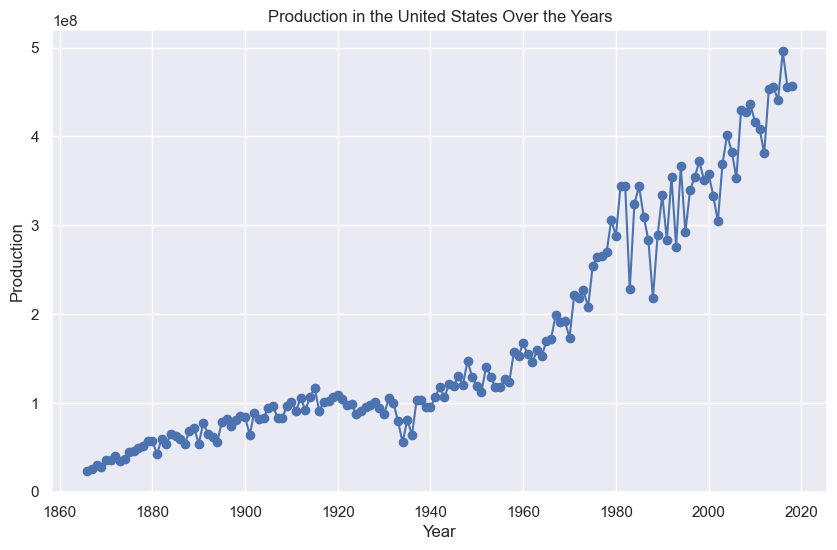

In [22]:
us_df = grouped_data[grouped_data['Country'] == 'United States']

plt.figure(figsize=(10, 6))
plt.plot(us_df['year'], us_df['production (tonnes)'], marker='o', linestyle='-', color='b')
plt.title('Production in the United States Over the Years')
plt.xlabel('Year')
plt.ylabel('Production')
plt.grid(True)
plt.show()

Th graph shows a growth in the production levels of crops (all of the crops combined) over the years. It has increased which is expected since the world keeps evolving. We also notice some dips in the production every now and then probably due to economic crisis.

Through this we can also see the different countries production in a certain year.

In [31]:
filtered_df = grouped_data.loc[grouped_data['year'] == 2017]
print(filtered_df.sort_values(by="production (tonnes)", ascending=False))

             Country  year  production (tonnes)
2361   United States  2017         4.559482e+08
760            China  2017         3.935749e+08
1131           India  2017         1.272300e+08
117        Argentina  2017         6.197796e+07
1013          France  2017         5.109660e+07
585           Canada  2017         4.407950e+07
263        Australia  2017         3.181874e+07
1480          Mexico  2017         3.126600e+07
475           Brazil  2017         3.004749e+07
2208  United Kingdom  2017         1.483837e+07
1850    South Africa  2017         1.474231e+07
1227       Indonesia  2017         1.171297e+07
1560         Morocco  2017         9.787246e+06
1355           Italy  2017         6.543045e+06
1948           Spain  2017         4.830281e+06
2074          Sweden  2017         3.298600e+06
377          Belgium  2017         1.702721e+06
320          Austria  2017         1.437143e+06
1662     Netherlands  2017         1.054000e+06
2472         Uruguay  2017         9.110

In [34]:
# Group the data by the 'Country' column and count the number of rows in each group
grouped_data = df.groupby(['Country', 'year'])['production (tonnes)'].sum().reset_index()
grouped_data

,Country,year,production (tonnes)
0,Argentina,1900,4545130.000
1,Argentina,1901,3668403.328
2,Argentina,1902,6607305.400
3,Argentina,1903,7978701.728
4,Argentina,1904,7677243.520
...,...,...,...
2470,Uruguay,2015,1670500.000
2471,Uruguay,2016,1244000.000
2472,Uruguay,2017,911000.000
2473,Uruguay,2018,1036600.000


We can also order the countries to see which was the most producing in one specific year.

In [35]:
filtered_df = grouped_data.loc[grouped_data['year'] == 2017]
print(filtered_df.sort_values(by="production (tonnes)", ascending=False))

             Country  year  production (tonnes)
2361   United States  2017         4.559482e+08
760            China  2017         3.935749e+08
1131           India  2017         1.272300e+08
117        Argentina  2017         6.197796e+07
1013          France  2017         5.109660e+07
585           Canada  2017         4.407950e+07
263        Australia  2017         3.181874e+07
1480          Mexico  2017         3.126600e+07
475           Brazil  2017         3.004749e+07
2208  United Kingdom  2017         1.483837e+07
1850    South Africa  2017         1.474231e+07
1227       Indonesia  2017         1.171297e+07
1560         Morocco  2017         9.787246e+06
1355           Italy  2017         6.543045e+06
1948           Spain  2017         4.830281e+06
2074          Sweden  2017         3.298600e+06
377          Belgium  2017         1.702721e+06
320          Austria  2017         1.437143e+06
1662     Netherlands  2017         1.054000e+06
2472         Uruguay  2017         9.110

For example, United States had the highest total production in 2017.

In [23]:
df.columns

Index(['Unnamed: 0', 'Harvest_year', 'Country', 'City', 'crop',
       'hectares (ha)', 'production (tonnes)', 'year', 'yield(tonnes/ha)'],
      dtype='object')

In [24]:
# Select specific columns and reorder them
df = df[['City', 'Country', 'year', 'Harvest_year', 'crop', 'hectares (ha)', 'yield(tonnes/ha)', 'production (tonnes)']]
df

City  Country  year  Harvest_year   crop  \
CropStats 59     Not defined  Austria  1961          1961  wheat   
          60     Not defined  Austria  1962          1962  wheat   
          61     Not defined  Austria  1963          1963  wheat   
          62     Not defined  Austria  1964          1964  wheat   
          63     Not defined  Austria  1965          1965  wheat   
...                      ...      ...   ...           ...    ...   
          36702     zhejiang    China  2013          2013  wheat   
          36703     zhejiang    China  2014          2014  wheat   
          36704     zhejiang    China  2015          2015  wheat   
          36705     zhejiang    China  2016          2016  wheat   
          36706     zhejiang    China  2017          2017  wheat   

                 hectares (ha)  yield(tonnes/ha)  production (tonnes)  
CropStats 59          275822.0          2.580000           711620.760  
          60          270351.0          2.612000           706156.812  
          61          274722.0          2.510000           689552.220  
          62          282967.0          2.652000           750428.484  
          63          275654.0          2.397000           660742.638  
...                        ...               ...                  ...  
          36702        75520.0          3.685117           278300.000  
          36703        82120.0          3.768875           309500.000  
          36704        89800.0          3.912027           351300.000  
          36705        76590.0          3.315054           253900.000  
          36706       103670.0          4.043600           419200.000  

[34066 rows x 8 columns]

In [25]:
df.columns

Index(['City', 'Country', 'year', 'Harvest_year', 'crop', 'hectares (ha)',
       'yield(tonnes/ha)', 'production (tonnes)'],
      dtype='object')

Let's make boxplots of our data to get a better look at it.

In [28]:
# Defining the features that we want to check in boxplots
n_variables = ['year', 'hectares (ha)', 'yield(tonnes/ha)', 'production (tonnes)']

Harvest year and year are pretty much identical so we're not plotting both, just year.

The median is:  1960.0
The mean is: 1956.143398109552


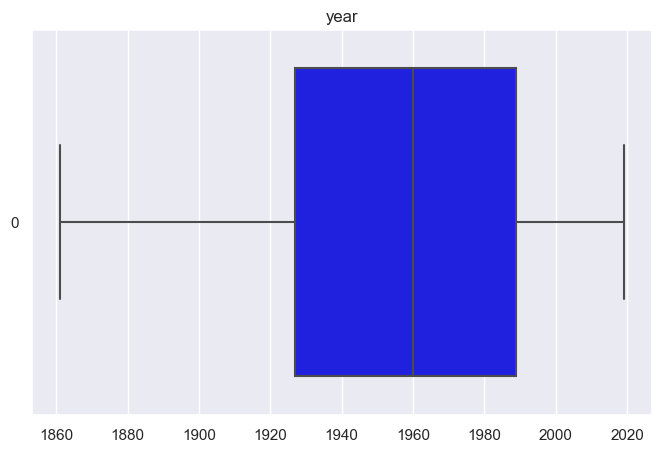

The median is:  179677.92
The mean is: 660998.1694192326


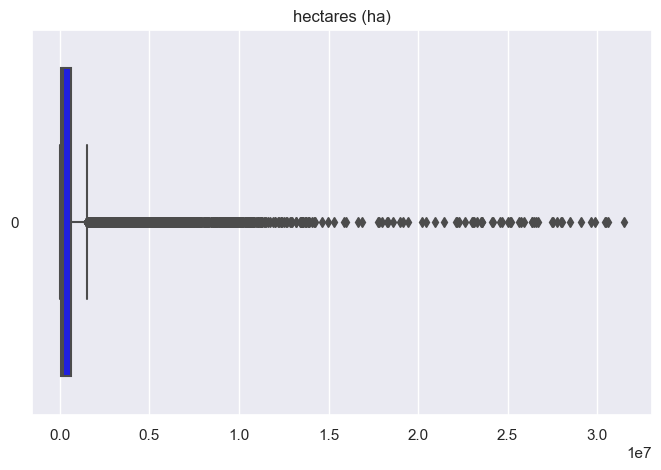

The median is:  1.883041353245194
The mean is: 2.6867739102923935


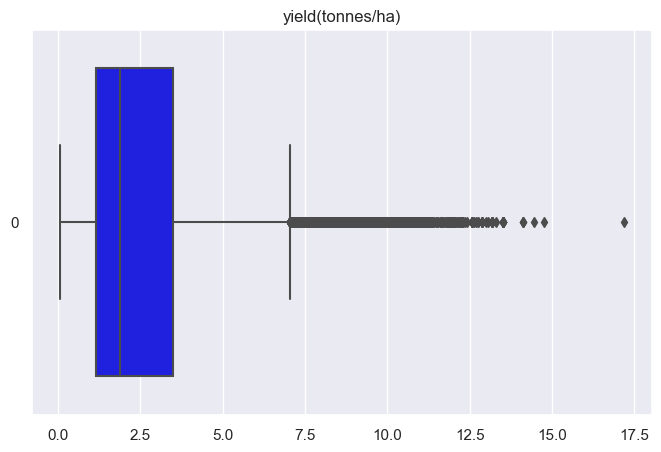

The median is:  333115.610711953
The mean is: 1638816.9535652723


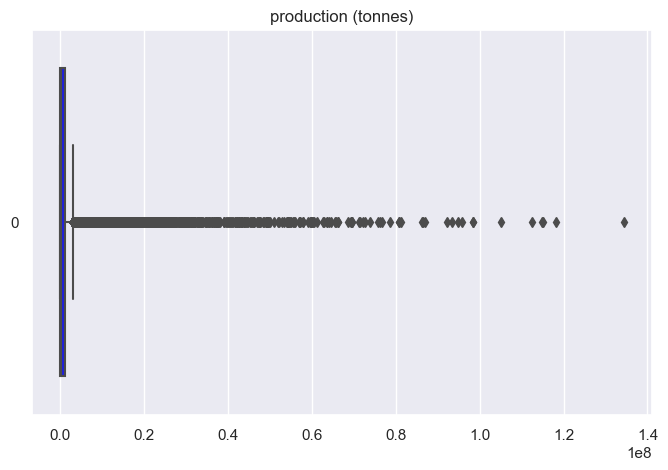

In [29]:
sns.set(rc={'figure.figsize':(8,5)})
for c in n_variables:
    x = df[c].values
    ax = sns.boxplot(x, orient='h', color= 'blue')
    print('The median is: ', df[c].median())
    print('The mean is:', df[c].mean())
    plt.title(c)
    plt.show()


We see that there's an enormous amount of outliers for production, hectares and yields. But in our case, this isn't a problem as we're looking at quantities of crops/land, so it's perfectly possible for there to be bigger/smaller numbers than the usual.

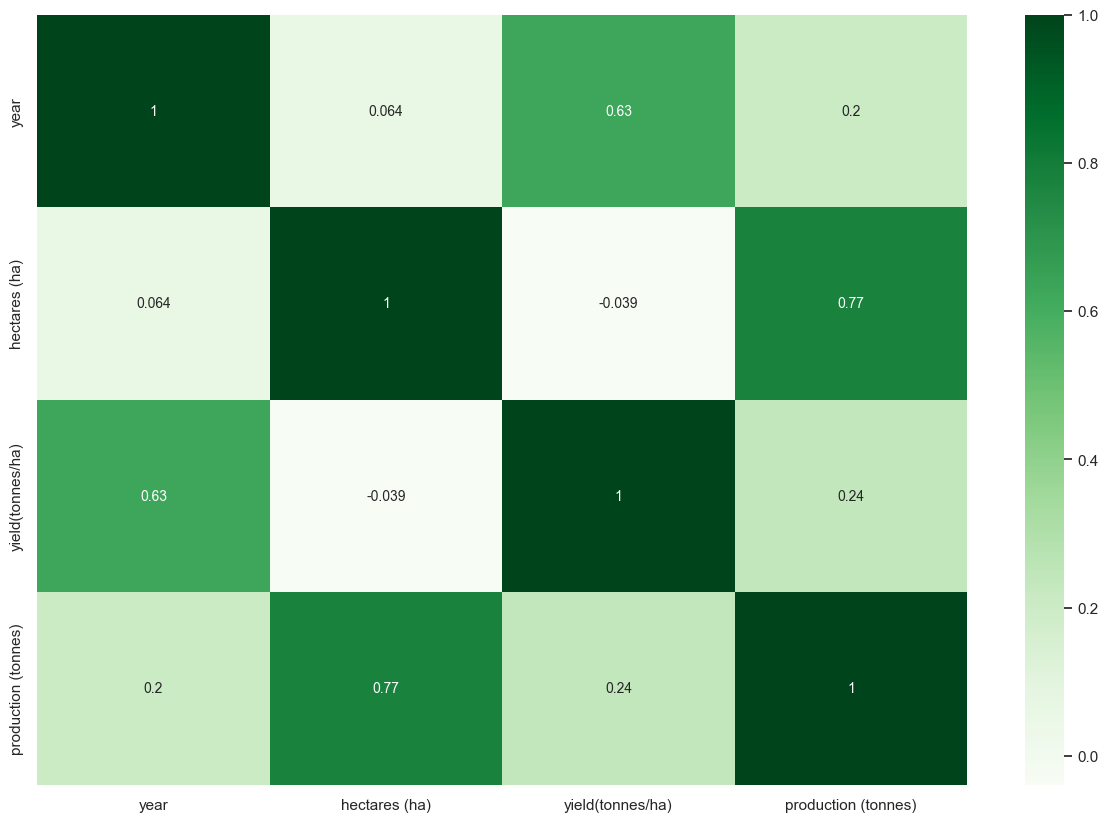

In [30]:
sns.set(rc={'figure.figsize':(15,10)})
pc =  df[n_variables].corr(method='pearson')
cols = n_variables
ax = sns.heatmap(pc, annot=True,
                 yticklabels=cols,
                 xticklabels=cols,
                 annot_kws={'size': 10},
                 cmap="Greens")

Since this is going to be a regression problem (numbers), our target variable is production. We can see that it has a strong positive correlation with hectares, and a weak positive correlation with year and yield.

In [31]:
pc

,year,hectares (ha),yield(tonnes/ha),production (tonnes)
year,1.000000,0.063877,0.630259,0.200599
hectares (ha),0.063877,1.000000,-0.038934,0.773770
yield(tonnes/ha),0.630259,-0.038934,1.000000,0.236045
production (tonnes),0.200599,0.773770,0.236045,1.000000


## Encoding categorical variable 'crop'

Crops are categorical, let's one hot encode them.

In [27]:
df_encoded = pd.get_dummies(df, columns=['crop'])
print(df_encoded.dtypes)
df_encoded.head()

City                    object
Country                 object
year                     int64
Harvest_year             int64
hectares (ha)          float64
yield(tonnes/ha)       float64
production (tonnes)    float64
crop_cereals              bool
crop_maize                bool
crop_spring wheat         bool
crop_wheat                bool
crop_winter wheat         bool
dtype: object


City  Country  year  Harvest_year  hectares (ha)  \
CropStats 59  Not defined  Austria  1961          1961       275822.0   
          60  Not defined  Austria  1962          1962       270351.0   
          61  Not defined  Austria  1963          1963       274722.0   
          62  Not defined  Austria  1964          1964       282967.0   
          63  Not defined  Austria  1965          1965       275654.0   

              yield(tonnes/ha)  production (tonnes)  crop_cereals  crop_maize  \
CropStats 59             2.580           711620.760         False       False   
          60             2.612           706156.812         False       False   
          61             2.510           689552.220         False       False   
          62             2.652           750428.484         False       False   
          63             2.397           660742.638         False       False   

              crop_spring wheat  crop_wheat  crop_winter wheat  
CropStats 59              False        True              False  
          60              False        True              False  
          61              False        True              False  
          62              False        True              False  
          63              False        True              False

## Trying a model with Standardization

In [28]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['Harvest_year','yield(tonnes/ha)', 'hectares (ha)', 'year']
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# Define your X (features) and Y (target)
X = df_encoded.drop(['production (tonnes)','City','Country'], axis=1)
y = df['production (tonnes)']

In [29]:
# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print('The Accuracy  on the testing dataset is: ', model.score(X_test, y_test) )

Mean Squared Error: 9456508742042.656
The Accuracy  on the testing dataset is:  0.6780490799053948


Let's do feature importance using models

In [35]:
df_encoded.columns

Index(['City', 'Country', 'year', 'Harvest_year', 'hectares (ha)',
       'yield(tonnes/ha)', 'production (tonnes)', 'crop_cereals', 'crop_maize',
       'crop_spring wheat', 'crop_wheat', 'crop_winter wheat'],
      dtype='object')

In [36]:
x = df_encoded.drop(['production (tonnes)', 'City', 'Country', 'Harvest_year'], axis = 1).values
x_columns = df_encoded.drop(['production (tonnes)', 'City', 'Country', 'Harvest_year'], axis=1)
y = df_encoded['production (tonnes)'].astype(int)

print(x.shape)
print(y.shape)

(34066, 8)
(34066,)


In [37]:
dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(x,y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

In [38]:
dt.feature_importances_

array([0.11675122, 0.50917488, 0.33166802, 0.        , 0.04240588,
       0.        , 0.        , 0.        ])

In [39]:
#del final_fi
for i, column in enumerate(df_encoded.drop(['production (tonnes)', 'City', 'Country', 'Harvest_year'], axis=1)):
    print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': [dt.feature_importances_[i]]})

    try:
        final_fi = pd.concat([final_fi, fi], ignore_index=True)
    except:
        final_fi = fi

final_fi = final_fi.sort_values('Feature Importance Score', ascending=False).reset_index()
final_fi


Importance of feature year:, 0.117
Importance of feature hectares (ha):, 0.509
Importance of feature yield(tonnes/ha):, 0.332
Importance of feature crop_cereals:, 0.000
Importance of feature crop_maize:, 0.042
Importance of feature crop_spring wheat:, 0.000
Importance of feature crop_wheat:, 0.000
Importance of feature crop_winter wheat:, 0.000


,index,Variable,Feature Importance Score
0,1,hectares (ha),0.509175
1,2,yield(tonnes/ha),0.331668
2,0,year,0.116751
3,4,crop_maize,0.042406
4,3,crop_cereals,0.000000
5,5,crop_spring wheat,0.000000
6,6,crop_wheat,0.000000
7,7,crop_winter wheat,0.000000


According to the feature importance analysis done using a decision tree classifier, hectares affect prodction levels the most. Let's try a linear regressor with only hectares, yield, and year (the top 3) as the 'x' values (features), and production as the y value (target variable).

In [40]:
x = df_encoded[['hectares (ha)', 'yield(tonnes/ha)', 'year']].astype(int)
x_columns = df_encoded.drop(['production (tonnes)', 'City', 'Country', 'Harvest_year'], axis=1)
y = df_encoded['production (tonnes)'].astype(int)

print('x shape: ', x.shape)
print('y shape: ', y.shape, '\n')

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, test_size=0.2, random_state=15)

print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

x shape:  (34066, 3)
y shape:  (34066,) 

x_train shape:  (27252, 3)
x_test shape:  (6814, 3)
y_train shape:  (27252,)
y_test shape:  (6814,)


In [41]:
lm = LinearRegression(fit_intercept=True)
lm.fit(x_train, y_train)

y_pred = lm.predict(x_test)

In [42]:
# Evaluate the model on the testing data
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print('Root mean squared error: ', rmse)
print('Root squared: ', r2)

Root mean squared error:  3077675.796465061
Root squared:  0.677518668520326


So far the r2 score is 0.677 with only 3 features. Let's try with all the features besides the production, city, and country.

In [43]:
x = df_encoded.drop(['production (tonnes)', 'City', 'Country', 'Harvest_year'], axis = 1).values
y = df_encoded['production (tonnes)'].astype(int)

print('x shape: ', x.shape)
print('y shape: ', y.shape, '\n')

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, test_size=0.2, random_state=15)

print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

lm = LinearRegression(fit_intercept=True)
lm.fit(x_train, y_train)

y_pred = lm.predict(x_test)

# Evaluate the model on the testing data
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print('\nRoot mean squared error: ', rmse)
print('Root squared: ', r2)

x shape:  (34066, 8)
y shape:  (34066,) 

x_train shape:  (27252, 8)
x_test shape:  (6814, 8)
y_train shape:  (27252,)
y_test shape:  (6814,)

Root mean squared error:  3077800.0497194333
Root squared:  0.6774926292839611


With all the features besides the production, city, and country, the Accuracy  on the testing dataset (r2 score) is the same 0.677. 
<br/>
It's not bad but perhaps we can do better

## Random forest regressor

#### Without outliers

First trying to remove all the outliers of production and see if that gives us a better accuracy. The IQR method is a commonly used technique for detecting outliers. It defines a range around the median (which is the second quartile, or 50th percentile) within which most of the data points are expected to fall. Data points that are significantly below the lower bound or above the upper bound are considered potential outliers. We use the factor of 1.5 as it is a common choice usually used to implement this method.

In [44]:
# Define the outlier boundaries (example using IQR method)
Q1 = df_encoded['production (tonnes)'].quantile(0.25)
Q3 = df_encoded['production (tonnes)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_filtered = df_encoded[(df_encoded['production (tonnes)'] >= lower_bound) & (df_encoded['production (tonnes)'] <= upper_bound)]

# Check the updated dataset
print("Original dataset size:", df_encoded.shape)
print("Filtered dataset size:", df_filtered.shape)


Original dataset size: (34066, 12)
Filtered dataset size: (30133, 12)


In [45]:
x3 = df_filtered.drop(['production (tonnes)', 'City', 'Country', 'Harvest_year'], axis = 1).values
y3 = df_filtered['production (tonnes)'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x3, y3, test_size=0.2, random_state=15)

regr = RandomForestRegressor(n_estimators=2000, max_depth=2, random_state=0)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred))

The Accuracy/R2 score on the testing dataset is:  0.5830450039865849
The RMSE on the testing dataset is:  441165.6404301502
The MAE on the testing dataset is:  290478.4412611586


The accuracy went down with a random forest regressor that only includes rows with production values that aren't outliers. Let's try including the outliers and see if that makes a difference.

#### With outliers

In [51]:
x4 = df_encoded.drop(['production (tonnes)', 'City', 'Country', 'Harvest_year'], axis = 1).values
y4 = df_encoded['production (tonnes)'].astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x4, y4, test_size=0.2, random_state=15)

regr2 = RandomForestRegressor(n_estimators=2000, max_depth=2, random_state=0)
regr2.fit(X_train, y_train)

y_pred2 = regr2.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr2.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred2)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred2))

The Accuracy/R2 score on the testing dataset is:  0.6274853303029349
The RMSE on the testing dataset is:  3307823.056428261
The MAE on the testing dataset is:  1011676.8306211033


## Decision tree regressor

#### Without outliers

In [57]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x3, y3, test_size=0.2, random_state=15)

regr3 = DecisionTreeRegressor(max_depth=5, random_state=0)
regr3.fit(X_train, y_train)
y_pred3 = regr3.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy on the testing dataset is: ', regr3.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred3)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred3))

The Accuracy on the testing dataset is:  0.8895022726913977
The RMSE on the testing dataset is:  227108.6953771615
The MAE on the testing dataset is:  132899.27448018466


The r-squared went up, the decision tree regressor does the best job so far. Perhaps with outliers it's better.

#### With outliers

In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x4, y4, test_size=0.2, random_state=15)

regr4 = DecisionTreeRegressor(max_depth=5, random_state=0)
regr4.fit(X_train, y_train)
y_pred4 = regr4.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr4.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred4)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred4))

The Accuracy/R2 score on the testing dataset is:  0.9502484108039881
The RMSE on the testing dataset is:  1208854.576300973
The MAE on the testing dataset is:  431126.7568433536


It did! It's the highest score thus far.

### Brief recap

So far we have tried a Linear regressor once with all numerical features, and once with 3 chosen features. We also tried Random Forest regressor and a Decision Tree regressor, once without samples that have the production (target variable) as an outlier, and once with the outliers. The R-squared is used for evaluating regression models. The following are the scores of each model:
- Linear regressor with only 3 features in x:            0.677518668520326
- Linear regressor with all numerical features in x:     0.6774926292839611
- Random Forest regressor without outliers:              0.5830450039865849
- Random Forest regressor with outliers:                 0.6274853303029349
- Decision Tree regressor without outliers:              0.8895022726913977
- Decision Tree regressor with outliers:                 0.9502484108039881


The Decision Tree regressor with outliers does the best job with an R-square of 0.9502484108039881

### Encoding Country

In [61]:
unique_vals_country = df['Country'].unique()
nr_values_country = len(unique_vals_country)
print('The number of unique values for Country :', nr_values_country)

The number of unique values for Country : 25


Country has 25 values, meaning 25 different countries. Some countries produce more than others, so perhaps adding Country to our best model (Decision Tree with outliers) might give an even higher score. One hot encoding 25 unique values for a categorical feature will result in 25 extra columns (features) in our dataframe, this increases the dimensionality (Curse of Dimensionality). Thus, we will use label-encoding instead, where each country will be represented by a unique number starting from 0 to 24.

In [65]:
df_encoded_2 = df_encoded.copy()
df_encoded_2['Country'] = pd.factorize(df_encoded['Country'])[0]
country_mapping = dict(enumerate(df_encoded['Country'].unique()))
print("Mapping of encoded values to countries:")
for encoded_value, country in country_mapping.items():
    print(f"{encoded_value}: {country}")

df_encoded_2

Mapping of encoded values to countries:
0: Austria
1: Belgium
2: Croatia
3: Czech Republic
4: Finland
5: Indonesia
6: Canada
7: Brazil
8: Australia
9: India
10: Spain
11: France
12: Chile
13: Mexico
14: South Africa
15: United Kingdom
16: United States
17: Portugal
18: Morocco
19: Uruguay
20: Argentina
21: Italy
22: Netherlands
23: Sweden
24: China


City  Country  year  Harvest_year  hectares (ha)  \
CropStats 59     Not defined        0  1961          1961       275822.0   
          60     Not defined        0  1962          1962       270351.0   
          61     Not defined        0  1963          1963       274722.0   
          62     Not defined        0  1964          1964       282967.0   
          63     Not defined        0  1965          1965       275654.0   
...                      ...      ...   ...           ...            ...   
          36702     zhejiang       24  2013          2013        75520.0   
          36703     zhejiang       24  2014          2014        82120.0   
          36704     zhejiang       24  2015          2015        89800.0   
          36705     zhejiang       24  2016          2016        76590.0   
          36706     zhejiang       24  2017          2017       103670.0   

                 yield(tonnes/ha)  production (tonnes)  crop_cereals  \
CropStats 59             2.580000           711620.760             0   
          60             2.612000           706156.812             0   
          61             2.510000           689552.220             0   
          62             2.652000           750428.484             0   
          63             2.397000           660742.638             0   
...                           ...                  ...           ...   
          36702          3.685117           278300.000             0   
          36703          3.768875           309500.000             0   
          36704          3.912027           351300.000             0   
          36705          3.315054           253900.000             0   
          36706          4.043600           419200.000             0   

                 crop_maize  crop_spring wheat  crop_wheat  crop_winter wheat  
CropStats 59              0                  0           1                  0  
          60              0                  0           1                  0  
          61              0                  0           1                  0  
          62              0                  0           1                  0  
          63              0                  0           1                  0  
...                     ...                ...         ...                ...  
          36702           0                  0           1                  0  
          36703           0                  0           1                  0  
          36704           0                  0           1                  0  
          36705           0                  0           1                  0  
          36706           0                  0           1                  0  

[34066 rows x 12 columns]

In [75]:
x5 = df_encoded_2.drop(['production (tonnes)', 'City', 'Harvest_year'], axis = 1).values
y5 = df_encoded_2['production (tonnes)'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(x5, y5, test_size=0.2, random_state=15)

regr5 = DecisionTreeRegressor(max_depth=5, random_state=0)
regr5.fit(X_train, y_train)
y_pred5 = regr5.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr5.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred5)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred5))

The Accuracy/R2 score on the testing dataset is:  0.9502484108039881
The RMSE on the testing dataset is:  1208854.576300973
The MAE on the testing dataset is:  431126.7568433536


Despite adding the Country, the score wasn't affected. Let's try performing hyperparameter tuning by tweaking the max_depth. Max_depth is a hyperparameter that determines the maximum depth or levels the decision tree can grow to during the training process.

In [90]:
regr6 = DecisionTreeRegressor(max_depth=21, random_state=0)
regr6.fit(X_train, y_train)
y_pred6 = regr6.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr6.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred6)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred6))

The Accuracy/R2 score on the testing dataset is:  0.9952737432106776
The RMSE on the testing dataset is:  372588.32063744543
The MAE on the testing dataset is:  62464.50281836963


After multiple attempts, it appears that 21 is the best maximum depth. It means that the tree is allowed to grow to a depth of 21 levels while making decisions and forming branches during the training process.

A max_depth of 21 is relatively deep and can result in a highly complex decision tree. Such a deep tree is capable of capturing very detailed and complex patterns in the training data. However, there is a trade-off to consider. Deeper trees are more likely to overfit the training data, which means they may perform exceptionally well on the training data but generalize poorly to new, unseen data. Overfitting can lead to a lack of model robustness.

Therefore, we shall stick to the former model (Decision Tree with outliers) with a score of 0.95 in order to avoid overfitting.

# Focusing on 1 country

Our model is predicting the production for any country, but since we know that each country is different, the accuracy might not be correct with new unseen data. Therefore, we shall dive deep into predicting the production for a specific country. We will choose the country with the highest number of samples (rows) since we need enough datapoints to train a model.

In [91]:
country_counts = df_encoded['Country'].value_counts()
print(country_counts)

United States     17833
France             4900
China              3371
Italy              1792
Spain              1625
Australia          1362
Brazil              555
Sweden              254
Mexico              246
Argentina           236
India               233
Canada              220
Uruguay             213
Netherlands         204
South Africa        200
Chile               176
United Kingdom      134
Indonesia            96
Portugal             87
Morocco              80
Belgium              57
Finland              57
Austria              57
Czech Republic       52
Croatia              26
Name: Country, dtype: int64


It appears that the United States has the most number of samples (17833). Let's make a dataframe with only those samples, then make a Decision tree regressor (including any outliers) with it and see what the r-squared would be then.

In [95]:
us_df = df_encoded[df_encoded['Country'] == 'United States']
print(us_df.shape)
us_df

(17833, 12)


City        Country  year  Harvest_year  \
CropStats 11597        ALABAMA  United States  2018          2018   
          11598        ARIZONA  United States  2018          2018   
          11599       ARKANSAS  United States  2018          2018   
          11600     CALIFORNIA  United States  2018          2018   
          11601       COLORADO  United States  2018          2018   
...                        ...            ...   ...           ...   
          29438       VIRGINIA  United States  1909          1909   
          29439     WASHINGTON  United States  1909          1909   
          29440  WEST VIRGINIA  United States  1909          1909   
          29441      WISCONSIN  United States  1909          1909   
          29442        WYOMING  United States  1909          1909   

                 hectares (ha)  yield(tonnes/ha)  production (tonnes)  \
CropStats 11597       44514.80          4.842106         2.155454e+05   
          11598       29946.32          6.886551         2.062922e+05   
          11599       38444.60          3.698831         1.422001e+05   
          11600       57869.24          5.460820         3.158339e+05   
          11601      790744.72          2.427778         1.918789e+06   
...                        ...               ...                  ...   
          29438      280443.24          0.786842         2.206619e+05   
          29439      397395.76          1.425731         5.665687e+05   
          29440       84578.12          0.827193         6.997061e+04   
          29441       25090.16          1.345030         3.374701e+04   
          29442        5260.84          1.197076         6.286741e+03   

                 crop_cereals  crop_maize  crop_spring wheat  crop_wheat  \
CropStats 11597             0           0                  0           1   
          11598             0           0                  0           1   
          11599             0           0                  0           1   
          11600             0           0                  0           1   
          11601             0           0                  0           1   
...                       ...         ...                ...         ...   
          29438             0           0                  0           0   
          29439             0           0                  0           0   
          29440             0           0                  0           0   
          29441             0           0                  0           0   
          29442             0           0                  0           0   

                 crop_winter wheat  
CropStats 11597                  0  
          11598                  0  
          11599                  0  
          11600                  0  
          11601                  0  
...                            ...  
          29438                  1  
          29439                  1  
          29440                  1  
          29441                  1  
          29442                  1  

[17833 rows x 12 columns]

In [110]:
x_us = us_df.drop(['production (tonnes)', 'City', 'Country', 'Harvest_year'], axis = 1).values
y_us = us_df['production (tonnes)'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(x_us, y_us, test_size=0.2, random_state=15)

regr_us = DecisionTreeRegressor(max_depth=5, random_state=0)
regr_us.fit(X_train, y_train)
y_pred_us = regr_us.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr_us.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_us)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_us))

The Accuracy/R2 score on the testing dataset is:  0.957970998975711
The RMSE on the testing dataset is:  761887.9450663972
The MAE on the testing dataset is:  318893.4653443036


In [111]:
y_train.shape
y_pred_us.shape

(3567,)

C:\Users\dinab\AppData\Local\Temp\ipykernel_31084\2895820894.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')


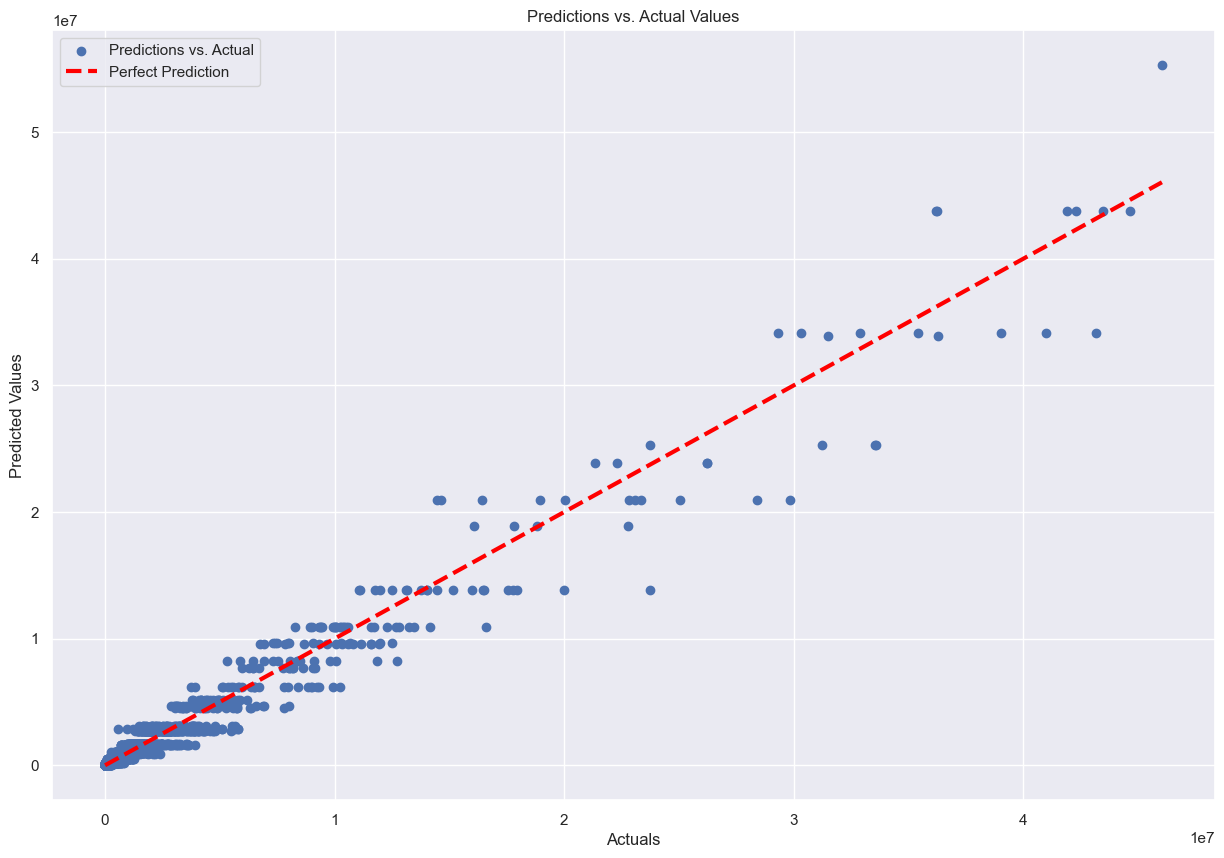

In [112]:
plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred_us, c='b', label='Predictions vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Predictions vs. Actual Values')
plt.show()


Out of cuiosity we'll see what this plot looks like when we train the model on a max depth of 21 (gave a 0.99 r-squared score).

The Accuracy/R2 score on the testing dataset is:  0.9923035748618243
The RMSE on the testing dataset is:  326032.6492771871
The MAE on the testing dataset is:  54296.03209045884


C:\Users\dinab\AppData\Local\Temp\ipykernel_31084\264507219.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')


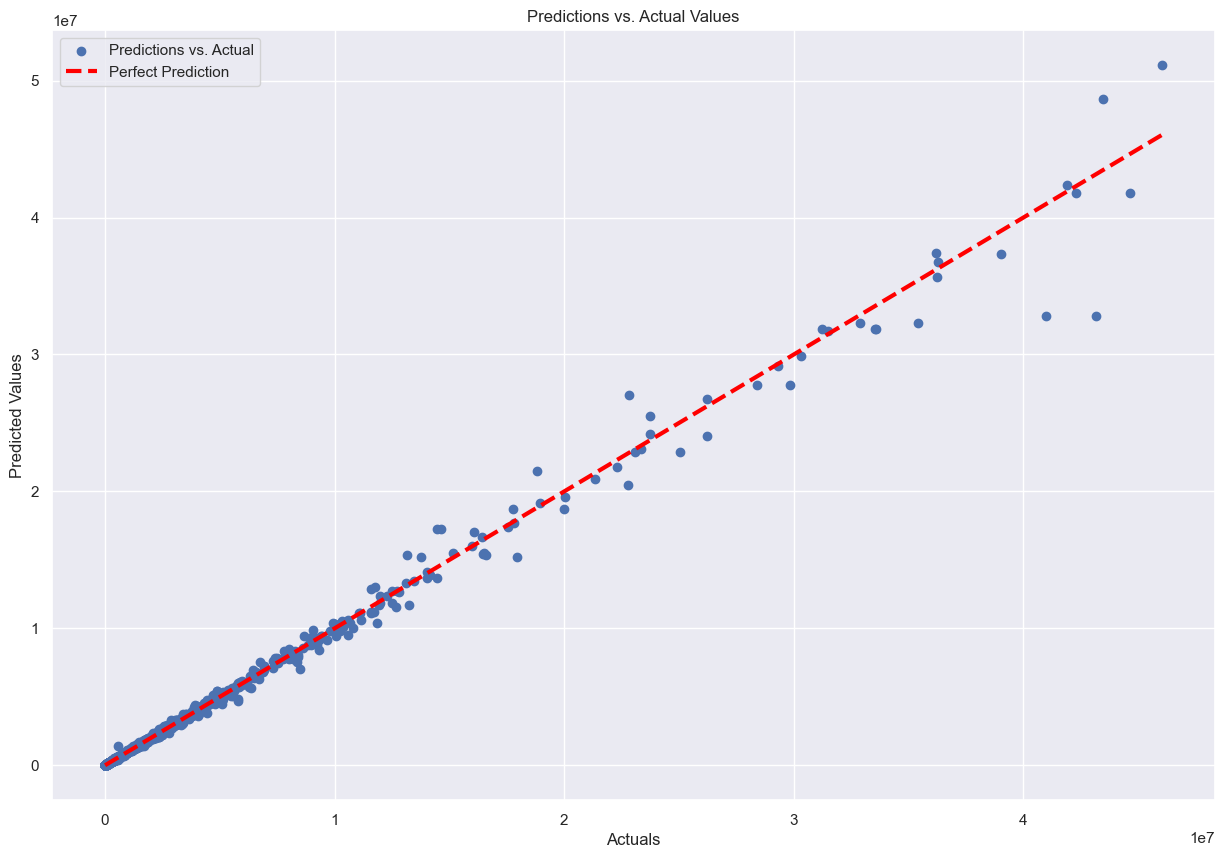

In [113]:
regr_us_2 = DecisionTreeRegressor(max_depth=21, random_state=0)
regr_us_2.fit(X_train, y_train)
y_pred_us_2 = regr_us_2.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr_us_2.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_us_2)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_us_2))

plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred_us_2, c='b', label='Predictions vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Predictions vs. Actual Values')
plt.show()


As expected, it is very accurate.

A thought that came to mind while discussing what to do with the dataset, is that including yield for the prediction is rather not fair since yield is ultimately a part of production (yield is the production in 1 hectare, while production is the total from all hectares). So, we will try making the prediction with multiple regressors, but this time excluding yield from the features. We w ill be predicting the production based on the country, crop, year, and number of hectares. Our hypothesis is that the score will go down but it will still be considered "good" (by good we mean sufficient for this task). This will also make the prediction more fair and actually "predicting" since the features to be included don't necessarily indicate whether or not the yield/production is high or low.

## Excluding yield


In [124]:
x_no_yield = df_encoded_2.drop(['production (tonnes)', 'City', 'Harvest_year', 'yield(tonnes/ha)'], axis = 1).values
y_no_yield = df_encoded_2['production (tonnes)'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(x_no_yield, y_no_yield, test_size=0.2, random_state=15)

regr_no_yield = DecisionTreeRegressor(max_depth=5, random_state=0)
regr_no_yield.fit(X_train, y_train)
y_pred_no_yield = regr_no_yield.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr_no_yield.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_no_yield)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_no_yield))

The Accuracy/R2 score on the testing dataset is:  0.867283138815873
The RMSE on the testing dataset is:  1974393.128834968
The MAE on the testing dataset is:  657826.4602749139


C:\Users\dinab\AppData\Local\Temp\ipykernel_31084\1828596632.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')


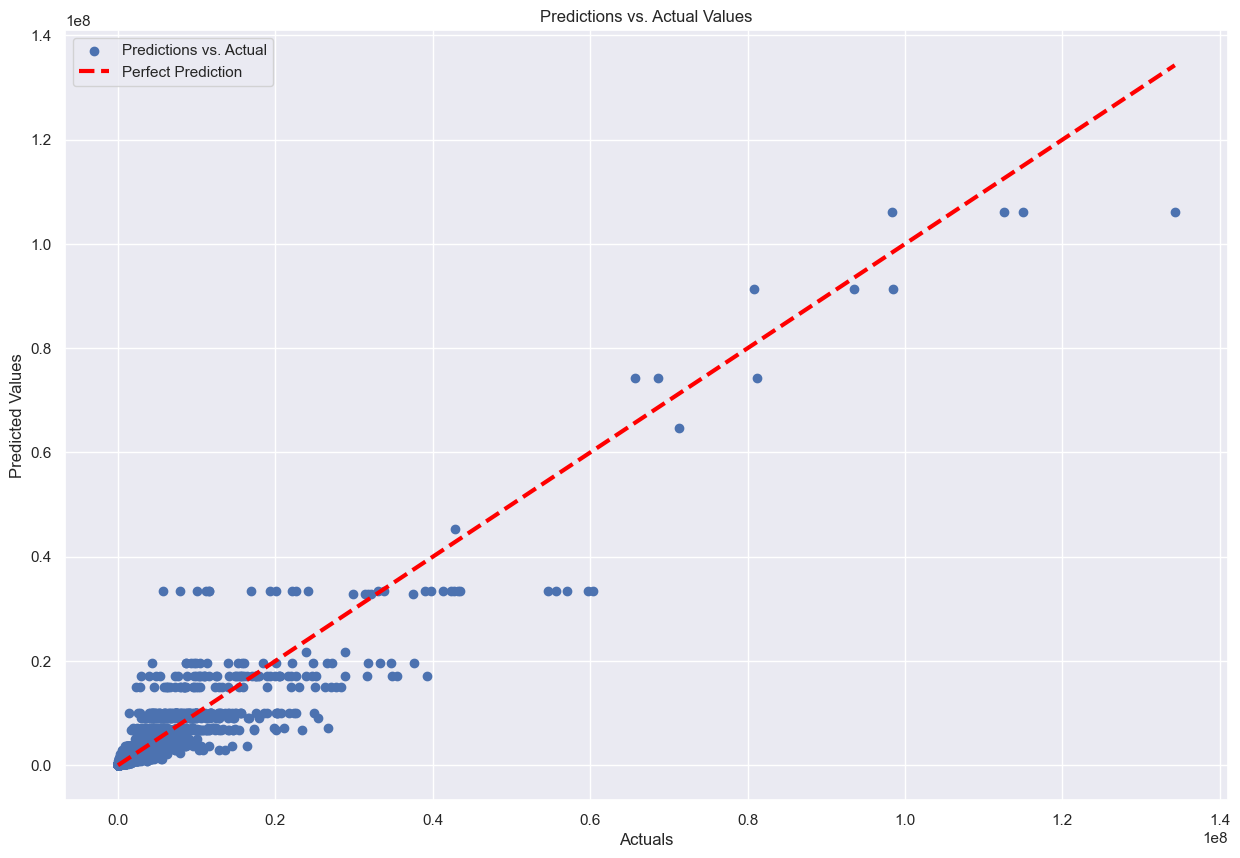

In [125]:
plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred_no_yield, c='b', label='Predictions vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Predictions vs. Actual Values')
plt.show()


As expected, with a max depth of 5, the score went down without the yield. We see a trend in the prediction where it predicts the same value for many test samples, hence the horizontal lines here and there. Perhaps it's cause 5 is too shallow, let's try increasing it by 1 level, so 6.

The Accuracy/R2 score on the testing dataset is:  0.9284370478258994
The RMSE on the testing dataset is:  1449822.0618070113
The MAE on the testing dataset is:  529870.9380199659


C:\Users\dinab\AppData\Local\Temp\ipykernel_31084\3867386680.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')


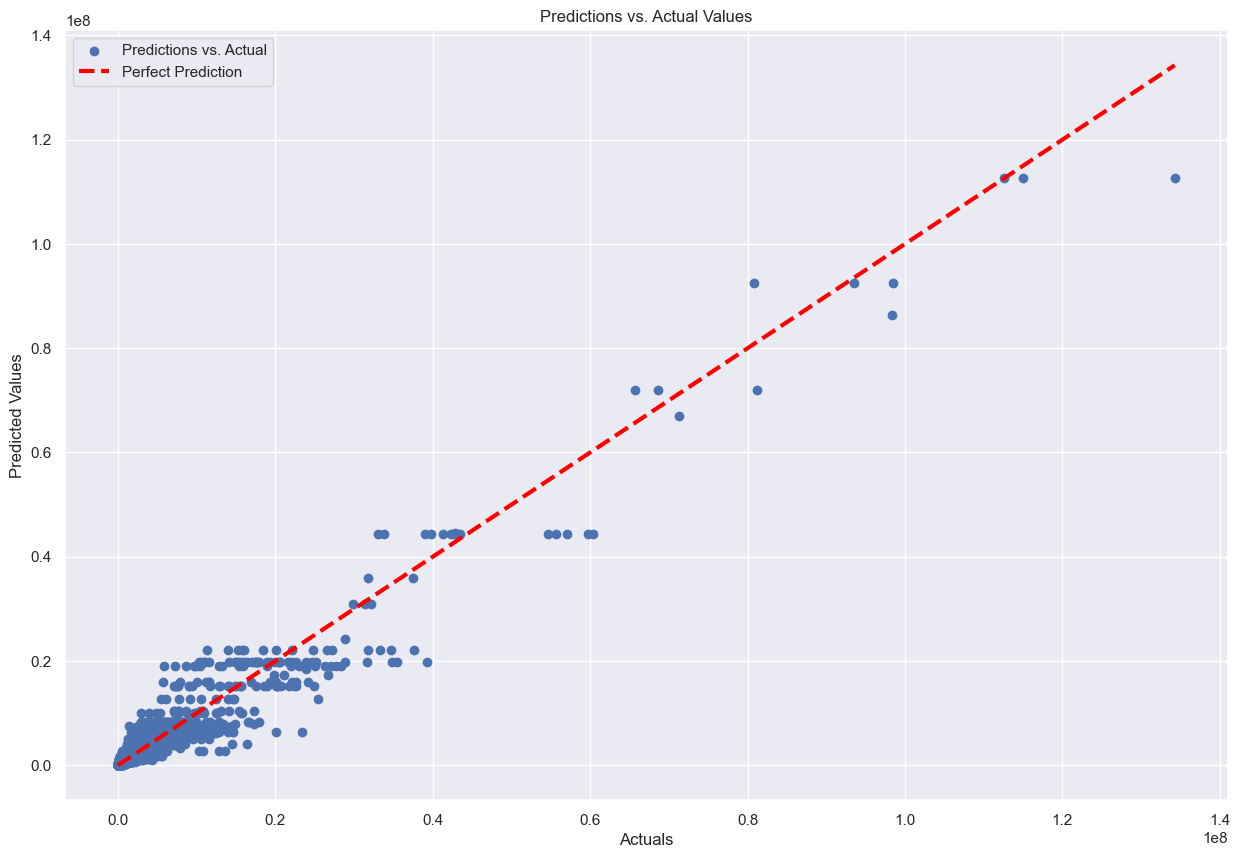

In [126]:
regr_no_yield_2 = DecisionTreeRegressor(max_depth=6, random_state=0)
regr_no_yield_2.fit(X_train, y_train)
y_pred_no_yield_2 = regr_no_yield_2.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr_no_yield_2.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_no_yield_2)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_no_yield_2))

plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred_no_yield_2, c='b', label='Predictions vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Predictions vs. Actual Values')
plt.show()


The accuracy increased considerabely but we still see the horizontal lines. Also we see that there's a cluster of datapoints in the lower numbers. Perhaps this is due to outliers being present. Let's try excluding those.

The Accuracy/R2 score on the testing dataset is:  0.8128516127634833
The RMSE on the testing dataset is:  295563.0463308693
The MAE on the testing dataset is:  168969.10020769268


C:\Users\dinab\AppData\Local\Temp\ipykernel_31084\397393462.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')


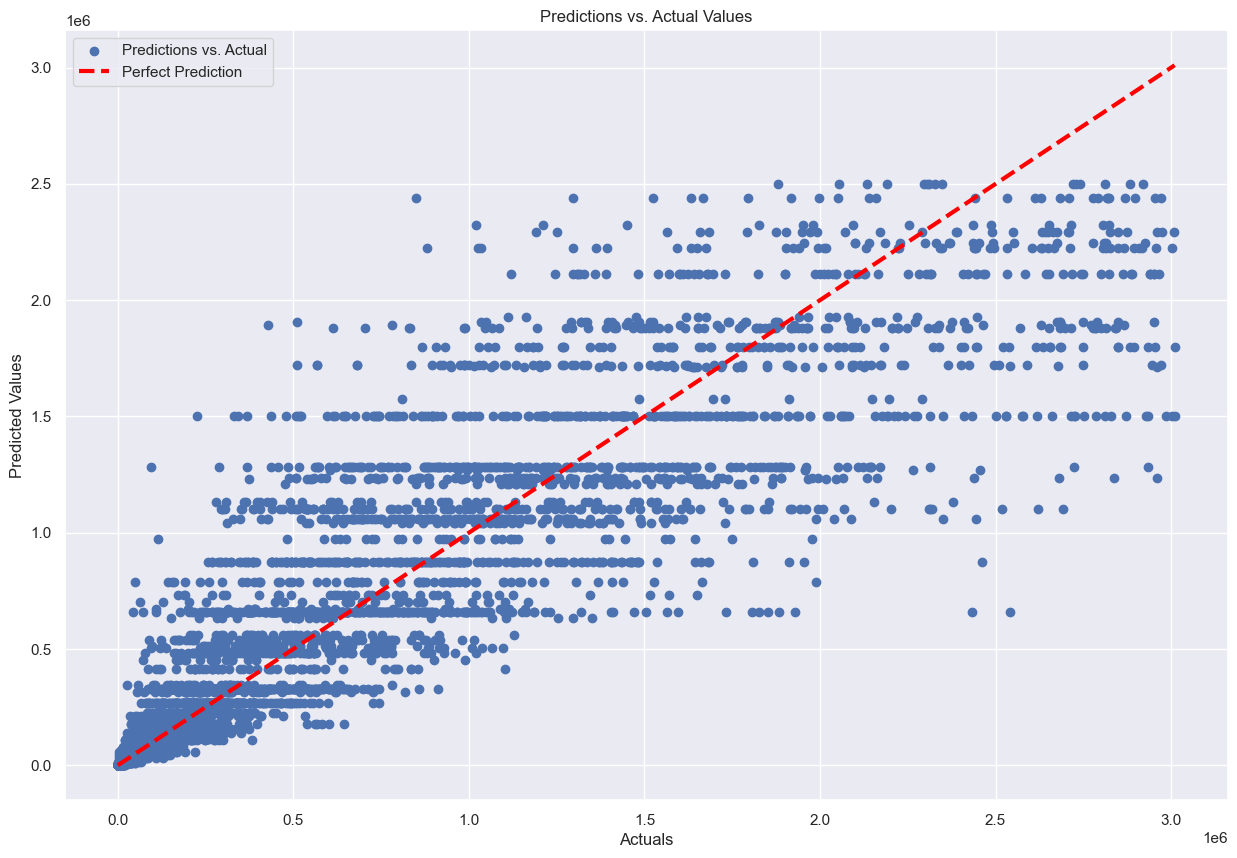

In [153]:
# Using the df_filtered from before
x_no_yield_or_outlier = df_filtered.drop(['production (tonnes)', 'City', 'Country', 'Harvest_year', 'yield(tonnes/ha)'], axis = 1).values
y_no_yield_or_outlier = df_filtered['production (tonnes)'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(x_no_yield_or_outlier, y_no_yield_or_outlier, test_size=0.2, random_state=15)

regr_no_yield_or_outlier = DecisionTreeRegressor(max_depth=6, random_state=0)
regr_no_yield_or_outlier.fit(X_train, y_train)
y_pred_no_yield_or_outlier = regr_no_yield_or_outlier.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr_no_yield_or_outlier.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_no_yield_or_outlier)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_no_yield_or_outlier))

plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred_no_yield_or_outlier, c='b', label='Predictions vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Predictions vs. Actual Values')
plt.show()


Interesting enough we now see the horizontal lines clearer. The accuracy right now (Decision Tree with a max depth of 6) is 0.81 which is good. Let's try with a bit higher like 8

The Accuracy/R2 score on the testing dataset is:  0.8220363505688448
The RMSE on the testing dataset is:  288219.0890546511
The MAE on the testing dataset is:  160996.35444920667


C:\Users\dinab\AppData\Local\Temp\ipykernel_31084\3879239860.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')


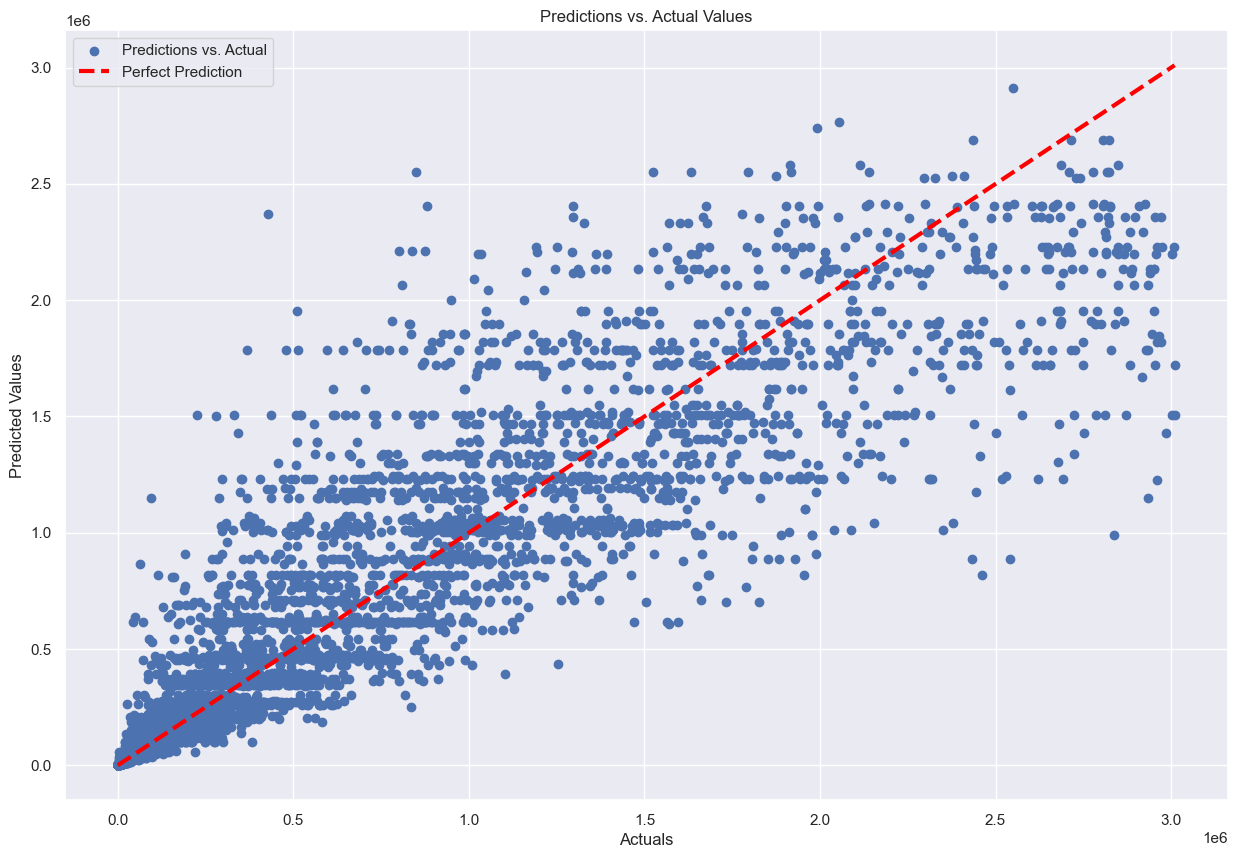

In [154]:
regr_no_yield_or_outlier_2 = DecisionTreeRegressor(max_depth=8, random_state=0)
regr_no_yield_or_outlier_2.fit(X_train, y_train)
y_pred_no_yield_or_outlier_2 = regr_no_yield_or_outlier_2.predict(X_test)

# Model Accuracy on testing dataset
print('The Accuracy/R2 score on the testing dataset is: ', regr_no_yield_or_outlier_2.score(X_test, y_test))
print('The RMSE on the testing dataset is: ', sqrt(mean_squared_error(y_test, y_pred_no_yield_or_outlier_2)))
print('The MAE on the testing dataset is: ', mean_absolute_error(y_test, y_pred_no_yield_or_outlier_2))

plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred_no_yield_or_outlier_2, c='b', label='Predictions vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', c='red', lw=3, label='Perfect Prediction')
plt.xlabel('Actuals')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Predictions vs. Actual Values')
plt.show()


What's noticable is that even though the score increased slightly (from 0.81 to 0.82), we can already see the predictions more varied and not just the exact same for many test samples. Not to say there aren't any horizontal lines but now they're less obvious in a way.

Out of curiosity we're looking at how other models may perform as well.

In [60]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=15)

# List of regressors to try
regressors = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor(),
    GradientBoostingRegressor()
]

# Train and evaluate each regressor
for regressor in regressors:
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Regressor: {regressor.__class__.__name__}")
    print(f"Mean Squared Error: {mse}")
    print("R-squared:", r2)
    print()

# You can add more regressors to the 'regressors' list as needed


Regressor: LinearRegression
Mean Squared Error: 9472853146052.945
R-squared: 0.6774926292839611

Regressor: Ridge
Mean Squared Error: 9472885154588.938
R-squared: 0.6774915395395491



c:\Users\dinab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.51957e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\dinab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e+16, tolerance: 6.545e+13
  model = cd_fast.enet_coordinate_descent(


Regressor: Lasso
Mean Squared Error: 9472853173606.568
R-squared: 0.6774926283458863

Regressor: ElasticNet
Mean Squared Error: 9508803972512.074
R-squared: 0.6762686678926424

Regressor: DecisionTreeRegressor
Mean Squared Error: 172864236913.84723
R-squared: 0.9941147625030851

Regressor: RandomForestRegressor
Mean Squared Error: 104384559221.17558
R-squared: 0.996446182663372

Regressor: SVR
Mean Squared Error: 31134430889431.99
R-squared: -0.059985126980961256

Regressor: KNeighborsRegressor
Mean Squared Error: 10771109783317.457
R-squared: 0.6332929221689743

Regressor: MLPRegressor
Mean Squared Error: 11233150072767.434
R-squared: 0.6175625612504712

Regressor: GradientBoostingRegressor
Mean Squared Error: 205460910396.5379
R-squared: 0.993004994696395



# Recap

The Decision Tree Regressor's model performed the best out of all the models. SPecifically the one exclusing yields. We chose this one because we think it's the most accurate and fair prediction. WIth max depth 5 it gave an accuracy score of 0.867283138815873. While with a max depth of 6 the accuracy score went up to 0.9284370478258994. Of course, the more you increase the  max depth value, the deeper the decision tree becomes (more branches), the higher the accuracy score gets. But to avoid overfitting we shall stop at 6.